# Linking molecule fragments via reaction SMIRKS

To test/develop SMIRFF force fields, it is extremely helpful to be able to generate molecules containing assorted combinations of various molecular fragments or substructures (i.e. substructures containing particular SMIRKS). Here, I experiment with using reaction SMIRKS to link substructures to generate libraries of molecules.

Library generation can be done by legitimate chemical reactions in order to expand libraries. However, here, I just want to link together sets of fragments with pre-specified attachment points. This can be done more simply by involving dummy elements which are present only to react. Here I'll make a `B` and `F` as caps of groups I want to link together in a library.

In [63]:
# Import OpenEye stuff
import openeye.oechem as oechem
import openeye.oedepict as oedepict
from IPython.display import display
import openeye.oeomega as oeomega

# Add utility function for depiction
def depict(mol, width=500, height=200):
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))


### Try out a simple reaction to link two SMILES strings

product smiles= COCCCOCOCOC


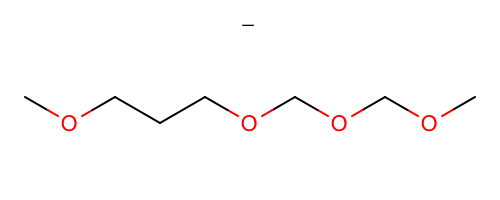

In [15]:
# Test by linking two molecules - anything with a C or O followed by a B can react with a C or O followed by an F to form 
# a bond betwen the two C or O atoms, dropping the B or F. 
libgen = oechem.OELibraryGen("[C,O:1][B:2].[C,O:3][F:4]>>[C,O:1][C,O:3]") 
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, 'COCCB')
libgen.SetStartingMaterial(mol, 0)
mol.Clear()
oechem.OESmilesToMol(mol, 'COCOCOCF')
libgen.SetStartingMaterial(mol, 1)

mols = []
for product in libgen.GetProducts():
    print("product smiles= %s" %oechem.OEMolToSmiles(product))
    mols.append(oechem.OEMol(product))
    
# Depict result
depict(mols[0])

## Proceed to library generation

### First, build some sets of molecules to link, capped by our "reactant" groups

In [57]:
# Build two small libraries of molecules for linking

# Build a first set of molecules
import itertools
smileslist1 = []
#Take all two-item combinations of entries in the list
for item in itertools.permutations(['C','O','c1ccccc1','CC', 'COC', 'CCOC', 'CCCOC', 'C1CC1', 'C1CCC1', 'C1CCCC1', 'C1CCCCC1','C1OCOCC1'], 2): 
    smileslist1.append( ''.join(item))
#Now cap all of them terminally with a reaction site
smileslist1_rxn = [ smi+'B' for smi in smileslist1]

# Build a second set of molecules in the same manner
smileslist2 = []
for item in itertools.permutations(['c1ccccc1OC','c1ccccc1COC','c1ccccc1O(CO)C','C(O)C','C(OCO)', 'C1OOC1','C1OCOC1', 'C1CCCCCCOC1','CO(COCO)C', 'COCO(O)OC'],2):
    smileslist2.append( ''.join(item))
# Cap all with reaction site
smileslist2_rxn = [smi + 'F' for smi in smileslist2]

### Now, generate our library

10890


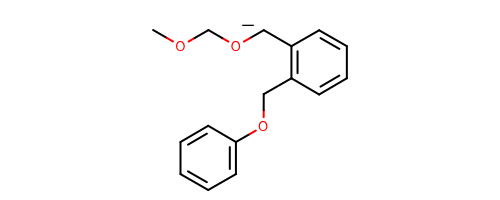

In [93]:
# Build overall set of reactants
libgen = oechem.OELibraryGen("[C,O:1][B:2].[C,O:3][F:4]>>[C,O:1][C,O:3]") 
mol = oechem.OEGraphMol()
for idx, smi in enumerate(smileslist1_rxn):
    oechem.OESmilesToMol(mol, smi)
    libgen.AddStartingMaterial(mol, 0)
    mol.Clear()
for idx, smi in enumerate(smileslist2_rxn):
    oechem.OESmilesToMol(mol, smi)
    libgen.AddStartingMaterial(mol, 1)
    mol.Clear()
    
products = [ oechem.OEMol(product) for product in libgen.GetProducts() ]
print len(products)
depict(products[0])


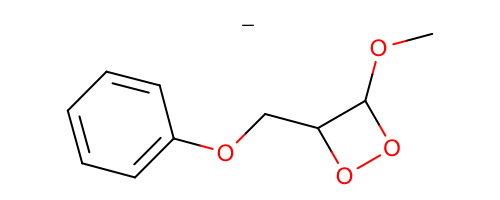

In [94]:
depict(products[4])


## Generate a conformer for each and write out

In [ ]:
omega = oeomega.OEOmega()
omega.SetMaxConfs(1)
omega.SetStrictStereo(False)
# First do just the first 10 molecules
#products = products[0:10]
ofs = oechem.oemolostream('linked_substructures.oeb')
for oemol in products:
    omega(oemol)
    oechem.OETriposAtomNames(mol)
    oechem.OEWriteMolecule(ofs, oemol)
ofs.close()


In [92]:
# Make sure I can read and write to mol2
ifs = oechem.oemolistream('linked_substructures.oeb')
ofs = oechem.oemolostream('linked_substructures_sample.mol2')
ct = 0
mol = oechem.OEMol()
while oechem.OEReadMolecule(ifs, mol):
    oechem.OEWriteMolecule(ofs, mol)
    ct+=1
    mol=oechem.OEMol()
    if ct > 10: break #Don't eat up tons of space, just test
ifs.close()
ofs.close()
    